In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
impact9x9=[
    [ 
        0x1 << c if r == 4 and c<4 
        else 0x1 << (c-1) if c>4 and r==4

        else 0x100 << c if c == 8-r and c<4
        else 0x100 << (c-1) if c == 8-r and c>4

        else 0x10000 << 8-r-1 if r<4 and c == 4  
        else 0x10000 << 8-r if r>4 and c==4

        else 0x1000000 << 8-c-1 if c == r and c<4
        else 0x1000000 << 8-c if c == r and c>4

        else 0
         for c in range(9) 
    ] for r in range(9) 
]
impact9x9

[[2147483648, 0, 0, 0, 8388608, 0, 0, 0, 32768],
 [0, 1073741824, 0, 0, 4194304, 0, 0, 16384, 0],
 [0, 0, 536870912, 0, 2097152, 0, 8192, 0, 0],
 [0, 0, 0, 268435456, 1048576, 4096, 0, 0, 0],
 [1, 2, 4, 8, 0, 16, 32, 64, 128],
 [0, 0, 0, 2048, 524288, 134217728, 0, 0, 0],
 [0, 0, 1024, 0, 262144, 0, 67108864, 0, 0],
 [0, 512, 0, 0, 131072, 0, 0, 33554432, 0],
 [256, 0, 0, 0, 65536, 0, 0, 0, 16777216]]

In [120]:
# l3 is the nw-line. point 2,2 on that line sees the stone at a distance of 2
x=impact9x9[2][2]
l0=(x & 0xFF)
l1=(x & 0xFF00) >> 8
l2=(x & 0xFF0000) >> 16
l3=(x & 0xFF000000) >> 24
[np.sign(l3 & (1<<i)) for i in range(8)]

[0, 0, 0, 0, 0, 1, 0, 0]

In [112]:
def stone_at(r,c, n=15):
    """
    Construct a complete nxn impact representation of a stone at row=r, col=c
    """
    src=np.hstack([
        np.zeros((n+8,c),dtype=np.int),
        np.vstack([
            np.zeros((r,9), dtype=np.int32), 
            impact9x9, 
            np.zeros((n-1-r,9), dtype=np.int32)
        ]),
        np.zeros((n+8,n-1-c),dtype=np.int)
    ])
    return (src[4:-4].T[4:-4].T).copy()

In [116]:
s77=stone_at(7,7, n=15)

In [117]:
np.shape(s77)

(15, 15)

In [118]:
np.log2(s77[3:-3].T[3:-3].T)

/Users/wgiersche/workspace/tutorials/other_stuff/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


array([[ 31., -inf, -inf, -inf,  23., -inf, -inf, -inf,  15.],
       [-inf,  30., -inf, -inf,  22., -inf, -inf,  14., -inf],
       [-inf, -inf,  29., -inf,  21., -inf,  13., -inf, -inf],
       [-inf, -inf, -inf,  28.,  20.,  12., -inf, -inf, -inf],
       [  0.,   1.,   2.,   3., -inf,   4.,   5.,   6.,   7.],
       [-inf, -inf, -inf,  11.,  19.,  27., -inf, -inf, -inf],
       [-inf, -inf,  10., -inf,  18., -inf,  26., -inf, -inf],
       [-inf,   9., -inf, -inf,  17., -inf, -inf,  25., -inf],
       [  8., -inf, -inf, -inf,  16., -inf, -inf, -inf,  24.]])

In [111]:
import sys
sys.getsizeof(s77)

1912

In [136]:
n=15
impacts=[[stone_at(r,c,n) for c in range(n)] for r in range(n)]

In [137]:
(impacts[0][14])

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      1,      2,      4,      8,      0],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,   2048, 524288],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,   1024,      0, 262144],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,    512,      0,      0, 131072],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,    256,      0,      0,      0,  65536],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     0,      0,      0,      0,  

In [139]:
(impacts[0][14] | impacts[1][14])[1][13]

2056

That's 2048 (bit 3 on north east line) and 8 (bit 3 on east line)

The above expression answers the question what an observer on (1,13) sees when (0,14) and (1,14) are occupied:
It sees the two stones in one step each to north east and east respectively. That's what we expect.
```
      (0,14)
(1,13)(1,14)
```

So, the full impact of an ensemble of stones on the entire field is simply computed by or-ing the pre-computed impacts of each stone within that ensemble. That's orders of magnitude faster than the for-comprehension we used in the naive approach.

---

In [1]:
import tensorflow as tf

In [2]:
black=0x8A458133
white=0x41824284

In [3]:
# neighbourhoods black and white
nb = tf.constant(black, dtype=tf.int32)
nw = tf.constant(white, dtype=tf.int32)

In [4]:
nw_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 0))
n_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 8))
ne_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 16))
e_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 24))

nw_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 0))
n_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 8))
ne_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 16))
e_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 24))

In [5]:
with tf.Session() as s:
    print(n_w.eval())

66


In [181]:
keys=[256*b+w for b in range(256) for w in range(256)]
values=keys
table = tf.contrib.lookup.HashTable(
        tf.contrib.lookup.KeyValueTensorInitializer(keys, values),
        0)

In [188]:
with tf.Session():
    table.init.run()
    out=table.lookup(tf.constant(10))
    print(out.eval())

10


In [193]:
class TotalScore:

    def __init__(self, kappa1):

        keys, values = ...TODO!
        
        self.kappa1 = kappa1
        self.table = tf.contrib.lookup.HashTable(
            tf.contrib.lookup.KeyValueTensorInitializer(keys, values),0)
    
    def as_tensor(self, nb, nw):    
        nw_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 0))
        n_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 8))
        ne_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 16))
        e_b = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nb, 24))

        nw_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 0))
        n_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 8))
        ne_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 16))
        e_w = tf.bitwise.bitwise_and(0xFF, tf.bitwise.right_shift(nw, 24)) 

        score_nw_w = self.table.lookup(256*nw_w + nw_b)
        score_n_w = self.table.lookup(256*n_w + n_b)
        score_ne_w = self.table.lookup(256*ne_w + ne_b)
        score_e_w = self.table.lookup(256*e_w + e_b)

        score_nw_b = self.table.lookup(256*nw_b + nw_w)
        score_n_b = self.table.lookup(256*n_b + n_w)
        score_ne_b = self.table.lookup(256*ne_b + ne_w)
        score_e_b = self.table.lookup(256*e_b + e_w)

        ts_w = tf.add( 
            tf.pow(score_nw_w, tf.kappa1),
            tf.add (
                tf.pow(score_n_w, tf.kappa1),
                tf.add (
                    tf.pow(score_ne_w, tf.kappa1), 
                    score_e_w)))

        ts_b = tf.add( 
            tf.pow(score_nw_b, tf.kappa1),
            tf.add (
                tf.pow(score_n_b, tf.kappa1),
                tf.add (
                    tf.pow(score_ne_b, tf.kappa1), 
                    score_e_b)))

        

In [207]:
b=0x81
hib=[4,0,1,0,2,0,1,0,3,0,1,0,2,0,1,0]
lob=[4,3,2,2,1,1,1,1,0,0,0,0,0,0,0,0]
rh = (b & 0xF0) >> 4
rl = b & 0xF
hib[rh]+lob[rl]

6

In [29]:
def central_mask(b):
    """
    determine a mask covering the 'central' zero bits
    e.g. central_mask( 0 1 0 0 | 0 0 1 1 ) =
                       0 0 1 1 | 1 1 0 0 = (60, 4)
    Args:
        b: an 8 bit integer representing a line of stones of one color
    Returns:
        a pair of tensors:
        1. A bit mask covering the central 'empty' region
        2. The length of that masked region.
    """
    hi_len  = tf.constant([4,0,1,0,2,0,1,0,3,0,1,0,2,0,1,0], dtype=tf.int32) 
    hi_mask = tf.constant(
        [0xF0,0x00,0x10,0x00,0x30,0x00,0x10,0x00,0x70,0x00,0x10,0x00,0x30,0x00,0x10,0x00], 
        dtype=tf.int32) # hi byte

    lo_len  = tf.constant([4,3,2,2,1,1,1,1,0,0,0,0,0,0,0,0], dtype=tf.int32)
    lo_mask = tf.constant(
        [0xF,0xE,0xC,0xC,0x8,0x8,0x8,0x8,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0], 
        dtype=tf.int32) # lo byte

    i_h = tf.bitwise.right_shift(tf.bitwise.bitwise_and(b, 0xF0), 4)
    i_l = tf.bitwise.bitwise_and(b, 0xF)

    return hi_mask[i_h] + lo_mask[i_l], hi_len[i_h] + lo_len[i_l]

In [30]:
bits = tf.placeholder(shape=(), dtype=tf.int32, name='bits')

In [31]:
cm_t = central_mask(bits)

In [32]:
with tf.Session() as sess:
    print(sess.run(cm_t, feed_dict={bits: 0x43}))

(60, 4)


In [1]:
from GomokuBoard import GomokuBoard
b = GomokuBoard(size=15, disp_width=6)

In [23]:
edges = b.all_edges(13,2)
edges

[(None, 6), (2, 6), (2, None), (2, None)]

In [22]:
[(0 if l is None else l+1, 9 if r is None else r+1) for l,r in edges]

[(0, 7), (3, 7), (3, 9), (3, 9)]

In [24]:
edge_masks=[
    (0xF, 4), (0x7, 3), (0x3, 2), (0x1, 1), (0x0, 0),
    (0x0, 0), (0x8, 1), (0xC, 2), (0xE, 3), (0xF, 4)
]

In [39]:
b.set(3,12).set(5,10).get_scores('b',1,14)

(0.0, 0.0)

---
---

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The old world
#### Good in memory consumption - but painfully slow 
You can watch the scores being displayed with significant time lapses inbetween.

In [14]:
import numpy as np
from GomokuBoard import GomokuBoard

(2.0, 0.0)
(0.0, 2.5198420997897464)
(2.8844991406148166, 0.0)


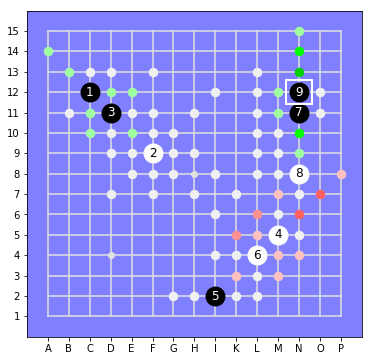

In [15]:
b = GomokuBoard(size=15, disp_width=6)
print(b.set(3,12).set(6,9).set(4,11).get_scores('b',2,13))
print(b.set(12,5).set(9,2).set(11,4).get_scores('b',13,6))
print(b.set(13,11).set(13,8).set(13,12).get_scores('b',13,13))
b.display(score='b')

---
## Trading memory for speed

#### Recording stone impacts

Every stone creates an *impression* on its adjacent positions. The reach of every stone is 4 in each direction, so the influence of a stone can be expressed as a matrix of $9 \times 9$ 32 bit integers representing the view on the stone from that position. This is what ```impact9x9``` is all about

In [16]:
impact9x9=[
    [ 
        0x1 << c if r == 4 and c<4 
        else 0x1 << (c-1) if c>4 and r==4

        else 0x100 << c if c == 8-r and c<4
        else 0x100 << (c-1) if c == 8-r and c>4

        else 0x10000 << 8-r-1 if r<4 and c == 4  
        else 0x10000 << 8-r if r>4 and c==4

        else 0x1000000 << 8-c-1 if c == r and c<4
        else 0x1000000 << 8-c if c == r and c>4

        else 0
         for c in range(9) 
    ] for r in range(9) 
]
impact9x9

[[2147483648, 0, 0, 0, 8388608, 0, 0, 0, 32768],
 [0, 1073741824, 0, 0, 4194304, 0, 0, 16384, 0],
 [0, 0, 536870912, 0, 2097152, 0, 8192, 0, 0],
 [0, 0, 0, 268435456, 1048576, 4096, 0, 0, 0],
 [1, 2, 4, 8, 0, 16, 32, 64, 128],
 [0, 0, 0, 2048, 524288, 134217728, 0, 0, 0],
 [0, 0, 1024, 0, 262144, 0, 67108864, 0, 0],
 [0, 512, 0, 0, 131072, 0, 0, 33554432, 0],
 [256, 0, 0, 0, 65536, 0, 0, 0, 16777216]]

It's much easier to see what's going on, if we look at the base-2 logarithms. Then what we get is the position of the single bit that is set for each number.

In [17]:
np.log2(impact9x9)

/Users/wgiersche/workspace/tutorials/other_stuff/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


array([[ 31., -inf, -inf, -inf,  23., -inf, -inf, -inf,  15.],
       [-inf,  30., -inf, -inf,  22., -inf, -inf,  14., -inf],
       [-inf, -inf,  29., -inf,  21., -inf,  13., -inf, -inf],
       [-inf, -inf, -inf,  28.,  20.,  12., -inf, -inf, -inf],
       [  0.,   1.,   2.,   3., -inf,   4.,   5.,   6.,   7.],
       [-inf, -inf, -inf,  11.,  19.,  27., -inf, -inf, -inf],
       [-inf, -inf,  10., -inf,  18., -inf,  26., -inf, -inf],
       [-inf,   9., -inf, -inf,  17., -inf, -inf,  25., -inf],
       [  8., -inf, -inf, -inf,  16., -inf, -inf, -inf,  24.]])

The central integer 0 is the position of the stone. If you go two steps north-east from there, you'll land at position $(6,2)$ with $V=8192$. Let's derive the meaning of that number. Each of the four bytes of the number describes a particular direction from east counter-clock-wise to north-west. So we'll look at the 8 bits of the seconde byte ```l1```: 

In [18]:
def as_bits(byte):
    return [np.sign(byte & (1<<i)) for i in range(8)]

def as_bitarray(code):
    # l3 is the nw-line. point 2,2 on that line sees the stone at a distance of 2
    l=code
    l0=(l & 0xFF)               # east
    l1=(l & 0xFF00) >> 8        # north east
    l2=(l & 0xFF0000) >> 16     # north
    l3=(l & 0xFF000000) >> 24   # north west
    return {
        'e': as_bits(l0),
        'ne': as_bits(l1),
        'n': as_bits(l2),
        'nw': as_bits(l3)
    }
as_bitarray(impact9x9[6][2])

{'e': [0, 0, 0, 0, 0, 0, 0, 0],
 'ne': [0, 0, 1, 0, 0, 0, 0, 0],
 'n': [0, 0, 0, 0, 0, 0, 0, 0],
 'nw': [0, 0, 0, 0, 0, 0, 0, 0]}

This 'ne' bit array represents the following line on the board: Position $V$ *sees* our stone 2 steps in sw-west direction, which is exactly what we wanted to achieve.
```
. . . . . . . . 0  
. . . . . . . 0 . 
. . . . . . 0 . . 
. . . . . 0 . . . 
. . . . V . . . .
. . . 0 . . . . .
. . 1 . . . . . .
. 0 . . . . . . .
0 . . . . . . . .
```

Now, this is all about performance in this notebook. We trade memory for speed. So we pre-compute the impact for each possible position on the entire board and store it! Hence, for each position we can just lookup the impact of a stone should we put it there. And the good news is: The bit representation of the total impact of any number of stones can simply be computed by bitwise or-ing each single impact. 

In the below implementation we even trade more memory for computational ease.

In [19]:
n = 15
def stone_at(r,c):
    """
    Construct a complete nxn impact representation of a stone at row=r, col=c
    """
    src=np.hstack([
        np.zeros((n+8,c),dtype=np.int),
        np.vstack([
            np.zeros((r,9), dtype=np.int32), 
            impact9x9, 
            np.zeros((n-1-r,9), dtype=np.int32)
        ]),
        np.zeros((n+8,n-1-c),dtype=np.int)
    ])
    return (src[4:-4].T[4:-4].T).copy()

stones = [[stone_at(r,c) for c in range(n)] for r in range(n)]

Let's look at an example, now in board coordinates, i.e. 1-15 left to right, 1-15 bottom up. The stone at (8,8) viewed from 2 steps nw, which is (6,10) results in the following representation.

In [20]:
def m2b(m, size=15):
    """matrix index to board position"""
    r, c = m
    return np.array([size-r, c+1])

def b2m(p, size=15):
    """board position to matrix index"""
    x, y = p
    return np.array([size-y, x-1])

In [21]:
rs, cs = b2m((8,8))
rv, cv = b2m((10,6))

as_bitarray(stones            
            [rs][cs]    # the stone
            [rv][cv]    # viewed from
           )   

{'e': [0, 0, 0, 0, 0, 0, 0, 0],
 'ne': [0, 0, 0, 0, 0, 0, 0, 0],
 'n': [0, 0, 0, 0, 0, 0, 0, 0],
 'nw': [0, 0, 1, 0, 0, 0, 0, 0]}

```
0 . . . . . . . .  
. 0 . . . . . . . 
. . 0 . . . . . . 
. . . 0 . . . . . 
. . . . V . . . .
. . . . . 0 . . .
. . . . . . 1 . .
. . . . . . . 0 .
. . . . . . . . 0
```

```stones``` is an array of 15x15 = 225 complete boards having pre-computed impacts for each field once occupied. The *or-ed* overlay of $n$ of those boards will represent the board having the $n$ stones on it.

In [22]:
r, c = b2m((1,1))
stones[r][c]

array([[      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,      

Now, the complete Gomoku board is represented by 2 overlays, one for the black stones, and one for the white ones.

In [23]:
class FastGomokuBoard:
    
    def __init__(self, size=15):
        self.current_color=0
        self.size = size
        self.impacts=[
            np.zeros([size,size], dtype=np.int32),
            np.zeros([size,size], dtype=np.int32)]
    
    def m2b(self, m):
        """matrix index to board position"""
        r, c = m
        return np.array([self.size-r, c+1])

    def b2m(self, p):
        """board position to matrix index"""
        x, y = p
        return np.array([self.size-y, x-1])

    def next(self):
        self.current_color = 1 - self.current_color
        return 1 - self.current_color
        
    def color_index(self, c):
        return 0 if c=='b' else 1
    
    def set(self, x,y):
        r, c = self.b2m((x,y))
        self.impacts[self.next()] |= stones[r][c]
        return self

    def getnh(self, x,y):
        r, c = self.b2m((x,y))
        return (self.impacts[0][r][c], self.impacts[1][r][c])
        

In [24]:
b1 = FastGomokuBoard()
b1.set(1,1)
b1.getnh(2,1)

(16, 0)

(2,1) sees (1,1) adjacent to the west: line=$[0,0,0,1,0,0,0,0] = 16$

---
## Counts and scores

In [25]:
b1 = FastGomokuBoard()
b1.set(4,4).set(6,4)
nh = b1.getnh(4,2)
nh

(262144, 1024)

In [26]:
from HeuristicScore import HeuristicScore
from LineScores import LineScoresHelper
h = HeuristicScore(kappa0=2, kappa1=5)
lsh = LineScoresHelper(h)

In [27]:
print(lsh.as_bits(49), lsh.as_bits(130))
lsh.lookup_score((43, 129))

[0, 0, 1, 1, 0, 0, 0, 1] [1, 0, 0, 0, 0, 0, 1, 0]


((2, 3), 2.491461879231035)

In [ ]:
for b in range(256):
    for w in range(256):
        line = [as_bits(b), as_bits(w)]
        score = lsh.lookup_score((b,w), 0)
        if score[0] != h.cscore(line, 0):
            raise AssertionError("scores for %s, %s don't match" % (b, w))
            
print("All 496 possible lines of eight stones yield the same score!")
# That assertion does even extend to illegal lines with two stones on top of each other.